# Блокнот №1.

### Введение

Данный блокнот иллюстрирует выполнение тестового задания №2 от NtechLab.

Задание: необходимо обучить нейросеть, способную по входному изображению лица
определять пол человека на изображении.

Изначально я начал работу в GoogleColab, но загрузка данных (с использованием драйва или напрямую) была очень нестабильной. Поэтому я переключился на работу в jupyter notebook, используя свою видеокарту (nvidia 1050ti).

**Предпринятые шаги**:

Подготовка данных: ознакомившись с изображениями, я решил на первых этапах не применять методы аугментации изображений по двум причинам - большое количество изображений для каждого класса и их разнообразие.

Обучение простой модели: я планирую обучить сначала простую модель с нуля, чтобы получить базовую метрику, которую в дальнейшем буду пытаться улучшить. Затем, чтобы сохранить время и ресурсы, я хочу воспользоваться уже обученной более сложной моделью, которую я "переобучу" для данной задачи. 

Формирование датасета: я воспользуюсь функционалом tf.keras для создания датасета напрямую из директории. На данном этапе я не вижу необходимости в тест сете, так что разбиваю данные только на тренировочный и валидационный датасеты.

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
# Silencing tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_hub as hub   

from sklearn.metrics import confusion_matrix
import pandas as pd

# Check for GPU availability
print("GPU", "available!" if tf.config.list_physical_devices("GPU") else "not available")

GPU available!


### Формирование датасета

Размер изображений я изменю на (96,96), так как в дальнейшем планирую применять обученные модели с tf.hub, для которых это один из стандартных размеров, и данный размер является наиболее подходящим для данного датасета (большинство изображений немного больше и мне бы не хотелось увеличивать их размер).
В дальнейшем этот параметр может быть пересмотрен.

In [2]:
data_dir = "./internship_data"
# Parameters setup
img_height, img_width = 96, 96
BATCH_SIZE = 32

In [3]:
# Loading training data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  label_mode = 'binary',
  validation_split=0.2,
  subset="training",
  seed = 123,
  image_size=(img_height, img_width),
  batch_size=BATCH_SIZE)
# Loading validation data
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  label_mode = 'binary',
  validation_split=0.2,
  subset="validation",
  seed = 123,
  image_size=(img_height, img_width),
  batch_size=BATCH_SIZE)

# 0 - female, 1 - male
class_names = train_ds.class_names
# Additional shuffling and prefetching. (Consider AUTOTUNE).
train_ds = train_ds.shuffle(100).prefetch(3)
val_ds = val_ds.prefetch(3)

Found 100002 files belonging to 2 classes.
Using 80002 files for training.
Found 100002 files belonging to 2 classes.
Using 20000 files for validation.


### Последовательная CNN архитектура для получения базового результата
Подобный тип архитектур часто встречается в задачах по классификации изображений. Я использовал ее аналог для FashionMnist датасета и она дала неплохие результаты.
Потенциальные улучшения: добавить BatchNormalization и функцию изменения скорости обучения.

In [7]:
baseline_model = tf.keras.models.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 5, strides=2, padding='same', activation='relu'),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(64, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(1, activation="sigmoid")
])

loss = tf.keras.losses.BinaryCrossentropy()

baseline_model.compile(optimizer='adam',
              loss=loss,
              metrics=['accuracy'])

Для сравнений моделей я записываю логи, используя tensorboard, и для ускорения процесса обучения добавляю раннюю остановку.

In [8]:
tensorboard = tf.keras.callbacks.TensorBoard("./logs/base_1")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=4)

In [9]:
# Learning
epochs = 20
baseline_history = baseline_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose=1,
  callbacks=[tensorboard, early_stopping]
)

Epoch 1/20
2501/2501 [==============================] - 1101s 440ms/step - loss: 0.2321 - accuracy: 0.9006 - val_loss: 0.1554 - val_accuracy: 0.9356
Epoch 2/20
2501/2501 [==============================] - 100s 40ms/step - loss: 0.1277 - accuracy: 0.9515 - val_loss: 0.1064 - val_accuracy: 0.9609
Epoch 3/20
2501/2501 [==============================] - 101s 40ms/step - loss: 0.1036 - accuracy: 0.9614 - val_loss: 0.1067 - val_accuracy: 0.9597
Epoch 4/20
2501/2501 [==============================] - 100s 40ms/step - loss: 0.0875 - accuracy: 0.9674 - val_loss: 0.1001 - val_accuracy: 0.9635
Epoch 5/20
2501/2501 [==============================] - 100s 40ms/step - loss: 0.0734 - accuracy: 0.9728 - val_loss: 0.1089 - val_accuracy: 0.9649
Epoch 6/20
2501/2501 [==============================] - 100s 40ms/step - loss: 0.0615 - accuracy: 0.9776 - val_loss: 0.0953 - val_accuracy: 0.9667
Epoch 7/20
2501/2501 [==============================] - 100s 40ms/step - loss: 0.0513 - accuracy: 0.9814 - val_loss:

In [ ]:
# Saving model
model_path = "./models/baseline_1/"
baseline_model.save(model_path)

Функция для визуализации истории обучения

In [ ]:
def plot_histories(history, epochs):
    """
    Takes history object and plots Accuracy and Loss for training and validation sets.
    Arguments:
    history: tf.history object returned by .fit method
    epochs: number of epoch to draw
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.axhline(max(val_acc), ls="--", c="g", label='Max accuracy = {}'.format(round(max(val_acc),3)))
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='lower left')
    plt.title('Training and Validation Loss')
    plt.show()

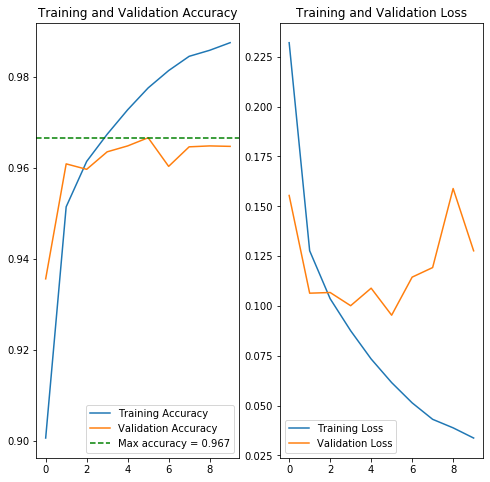

In [20]:
plot_histories(baseline_history, 10)

Модель хорошо справляется с тренировочным сетом, но довольно быстро перестает быть достаточно обобщенной для валидационных данных.

### Использование MobileNet V2 (03_96)
После загрузки и первичной подготовки данных (изменение размера изображений) и тренировки с нуля базовой модели (последовательной CNN с 5 обучаемыми слоями), мы получили почти 97% точности на валидационном сете. 
 
Следующими шагами могут быть - использование уже обученной сети или улучшение базовой модели.

Я остановился на первом подходе - использую обученную модель для извлечения "признаков" из изображения и на их основе провожу классификацию.

Я выбрал MobileNet V2 архитектуру из-за её эффективности. Я взял самую неглубокую версию с самым малым ожидаемым размером изображения (96х96). Низкая глубина модели обусловлена невысокой сложностью задачи: небольшое количество классов и то, что объект размещен почти на всей картинке. А малый размер изображений выбран потому, что средний размер невелик (множество изображений даже меньше 96х96). 


In [21]:
# Links to model for loading
handle_base = "mobilenet_v2_035_96"
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)
print("Using {} with input size {}".format(MODULE_HANDLE, (img_height, img_width)))

Using https://tfhub.dev/google/imagenet/mobilenet_v2_035_96/feature_vector/4 with input size (96, 96)


### Создаем модель
* Первый слой нормализует изображения
* Второй использует загруженную модель (training=False для BN слоев)
* Третий - дропаут, для генерализации модели
* Полностью соединённый слой с сигмоид активацией для получения вероятности принадлежности к классу

In [22]:
# Loaded part of the model
base_model = hub.KerasLayer(MODULE_HANDLE, trainable=False)

inputs = layers.Input(shape=(img_height, img_width, 3))
# Normalization of inputs
x = layers.experimental.preprocessing.Rescaling(1./255)(inputs)
x = base_model(x, training=False)
x = layers.Dropout(rate=0.2)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

mobilev2_model = tf.keras.Model(inputs, outputs)

mobilev2_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 96, 96, 3)         0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 1280)              410208    
_________________________________________________________________
dropout_4 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1281      
Total params: 411,489
Trainable params: 1,281
Non-trainable params: 410,208
_________________________________________________________________


### Тренируем только последний слой модели.
Чтобы не навредить весам загруженной модели, мы тренируем только новый слой, ответственный за классификацию по признакам, полученным от уже обученной части модели.
Для ускорения процесса обучения к оптимизатору добавил моментум с угасанием.

In [23]:
mobilev2_model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9, decay=0.01), 
  loss=tf.keras.losses.BinaryCrossentropy(),
  metrics=['accuracy'])

mobilev2_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=15,
  verbose=1
)

Epoch 1/15
2501/2501 [==============================] - 102s 41ms/step - loss: 0.4981 - accuracy: 0.8635 - val_loss: 0.2415 - val_accuracy: 0.9039
Epoch 2/15
2501/2501 [==============================] - 98s 39ms/step - loss: 0.2859 - accuracy: 0.8842 - val_loss: 0.2577 - val_accuracy: 0.8924
Epoch 3/15
2501/2501 [==============================] - 98s 39ms/step - loss: 0.2738 - accuracy: 0.8880 - val_loss: 0.2346 - val_accuracy: 0.9065
Epoch 4/15
2501/2501 [==============================] - 97s 39ms/step - loss: 0.2689 - accuracy: 0.8893 - val_loss: 0.2315 - val_accuracy: 0.9069
Epoch 5/15
2501/2501 [==============================] - 97s 39ms/step - loss: 0.2653 - accuracy: 0.8908 - val_loss: 0.2332 - val_accuracy: 0.9061
Epoch 6/15
2501/2501 [==============================] - 97s 39ms/step - loss: 0.2630 - accuracy: 0.8926 - val_loss: 0.2318 - val_accuracy: 0.9082
Epoch 7/15
2501/2501 [==============================] - 97s 39ms/step - loss: 0.2604 - accuracy: 0.8919 - val_loss: 0.2315 

In [ ]:
# Saving model
model_path = "./models/mobilev2_top_15ep"
mobilev2_model.save(model_path)

### Тренируем всю модель
Теперь мы размораживаем загруженную модель. Чтобы не навредить тонко настроенным весам модели, скорость обучения должна быть значительно снижена. По рекомендации документации tensorflow изменил оптимизатор на RMSprop.
Экспериментальным путем я получил, что lr = 0.0001 не разрушает модель (первая попытка с 0.001 привела к взрыву градиентов). Но для дополнительной надежности я добавил "1cycle scheduling". Обучение начинается с очень малой скоростью, постепенно растет, и после заданного количества эпох начинает вновь снижаться. Далее изображен график изменений

In [ ]:
# Loading model if session were interrupted
# mobilev2_model = tf.keras.models.load_model('./models/mobilev2_top_15ep')

In [24]:
base_model.trainable = True
mobilev2_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 96, 96, 3)         0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 1280)              410208    
_________________________________________________________________
dropout_4 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1281      
Total params: 411,489
Trainable params: 397,409
Non-trainable params: 14,080
_________________________________________________________________


In [2]:
# Learning rate schedule function
def one_cycle_scheduler(epoch, lr):
    if epoch < 10:
        return 1.6 * lr
    else:
        return lr * tf.math.exp(-0.1)

tensorboard = tf.keras.callbacks.TensorBoard("./logs/mobilev2_1")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=7, 
                                                 restore_best_weights=True)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
    one_cycle_scheduler, verbose=1)

**Визуализация расписания обучения**
После первого эксперимента я знал, что значения свыше 1е-4 на начальных этапах начинают вредить модели. Поэтому я использую эту скорость как максимальную. 

Начальное значение будет в сто раз меньше (1е-6) и после разогрева модели, скорость начинает постепенно уменьшаться.

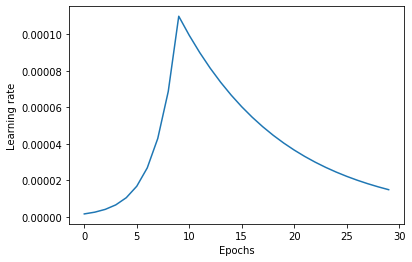

In [3]:
lr = 1e-6
lrs = []
for epoch in range(30):
    lr = one_cycle_scheduler(epoch, lr)
    lrs.append(lr)
plt.plot(range(30), lrs)
plt.xlabel("Epochs")
plt.ylabel("Learning rate");

In [28]:
# Changing optimizer and starting learning rate
mobilev2_model.compile(
  optimizer=tf.keras.optimizers.RMSprop(lr=1e-6),
  loss=tf.keras.losses.BinaryCrossentropy(),
  metrics=['accuracy'])

epochs = 30
# Training
mobilev2_history = mobilev2_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[tensorboard, early_stopping, lr_scheduler],
  verbose=1
)


Epoch 00001: LearningRateScheduler reducing learning rate to 1.5999999959603884e-06.
Epoch 1/30
   2/2501 [..............................] - ETA: 32:29 - loss: 0.3684 - accuracy: 0.8594WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0460s vs `on_train_batch_end` time: 1.5149s). Check your callbacks.


2501/2501 [==============================] - 172s 69ms/step - loss: 0.2676 - accuracy: 0.9026 - val_loss: 0.2310 - val_accuracy: 0.9200

Epoch 00002: LearningRateScheduler reducing learning rate to 2.5600000299164097e-06.
Epoch 2/30
2501/2501 [==============================] - 170s 68ms/step - loss: 0.2362 - accuracy: 0.9160 - val_loss: 0.2075 - val_accuracy: 0.9306

Epoch 00003: LearningRateScheduler reducing learning rate to 4.095999975106679e-06.
Epoch 3/30
2501/2501 [==============================] - 169s 68ms/step - loss: 0.2069 - accuracy: 0.9291 - val_loss: 0.1859 - val_accuracy: 0.9385

Epoch 00004: LearningRateScheduler reducing learning rate to 6.553599814651534e-06.
Epoch 4/30
2501/2501 [==============================] - 170s 68ms/step - loss: 0.1834 - accuracy: 0.9390 - val_loss: 0.1674 - val_accuracy: 0.9459

Epoch 00005: LearningRateScheduler reducing learning rate to 1.048575941240415e-05.
Epoch 5/30
2501/2501 [==============================] - 169s 68ms/step - loss: 0.1

In [35]:
# Saving model
model_path = "./models/mobilev2_28epochs_1cycle/"
mobilev2_model.save(model_path)

INFO:tensorflow:Assets written to: ./models/mobilev2_28epochs_1cycle/assets


INFO:tensorflow:Assets written to: ./models/mobilev2_28epochs_1cycle/assets


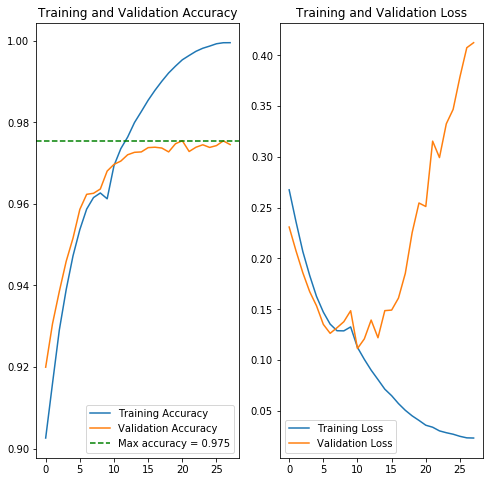

In [33]:
plot_histories(mobilev2_history, epochs=28)

Глядя на график, можно сказать, что модель начала переобучаться. Стандартным решением будет увеличить количество данных. Этого можно достичь путем аугментации изображений. Перед тем как приступить к этому, я хочу провести небольшой анализ ошибок.

### Анализ ошибок

In [ ]:
# Loading model if session were interrupted
# mobilev2_model = tf.keras.models.load_model('./models/mobilev2_28epochs_1cycle/')

Дополнительные функции для удобства анализа

In [36]:
def unbatchify(data, max_size=1000):
    """
    Takes a batched dataset of (image, label) Tensors and returns
    two arrays of images and labels
    """
    images = []
    labels = []
    for i, (image, label) in enumerate(data.unbatch().as_numpy_iterator()):
        images.append(image.astype(int))
        labels.append(label.astype(int))
        if i + 2 > max_size:
            break 
    return np.array(images), np.array(labels).squeeze()

def plot_predictions(images, y_pred=None, y_true=None, n_cols=5, figsize=(12,8)):
    """
    Takes images and plots them
    Predicted and true labels can be provided for additional visualisation.
    """
    n = len(images)
    n_rows = n // n_cols + 1
    plt.figure(figsize=figsize)
    for i, image in enumerate(images):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(image)
        plt.axis('off')
        if y_pred is not None:
            # Change color if prediction right
            pred_class = class_names[np.round(y_pred[i]).astype(int)]
            true_class = class_names[np.round(y_true[i]).astype(int)]
            if pred_class == true_class:
                color = "green"
            else:
                color = "red"
            confidence = round(abs(0.5 - y_pred[i]) * 200, 2)
            plt.title("{}, {:2.0f}% confidence".format(pred_class,
                                                       confidence),
                                                color=color)


Берем выборку из 1000 изображений из валидационного сета и визуализируем результаты.

In [37]:
# Sample of 1 thousand
images, labels = unbatchify(val_ds, max_size=1000)
predictions = mobilev2_model.predict(images).squeeze()

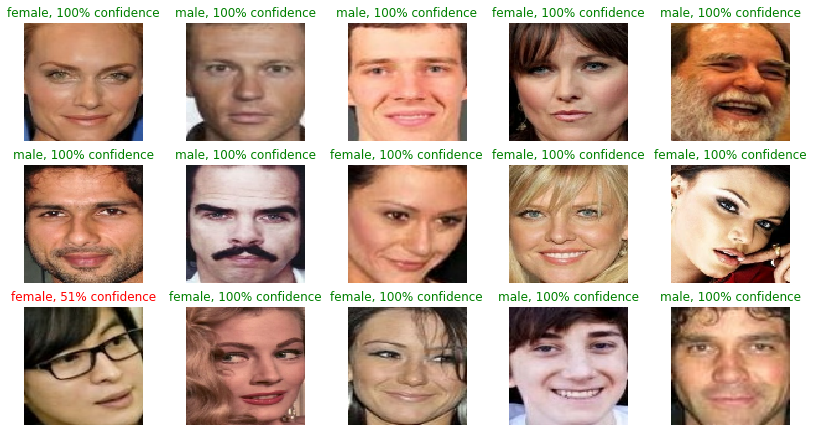

In [38]:
i, j = 25, 40
plot_predictions(images[i:j], predictions[i:j], labels[i:j], figsize=(14,10), n_cols=5)

Посмотрим только на ошибки.

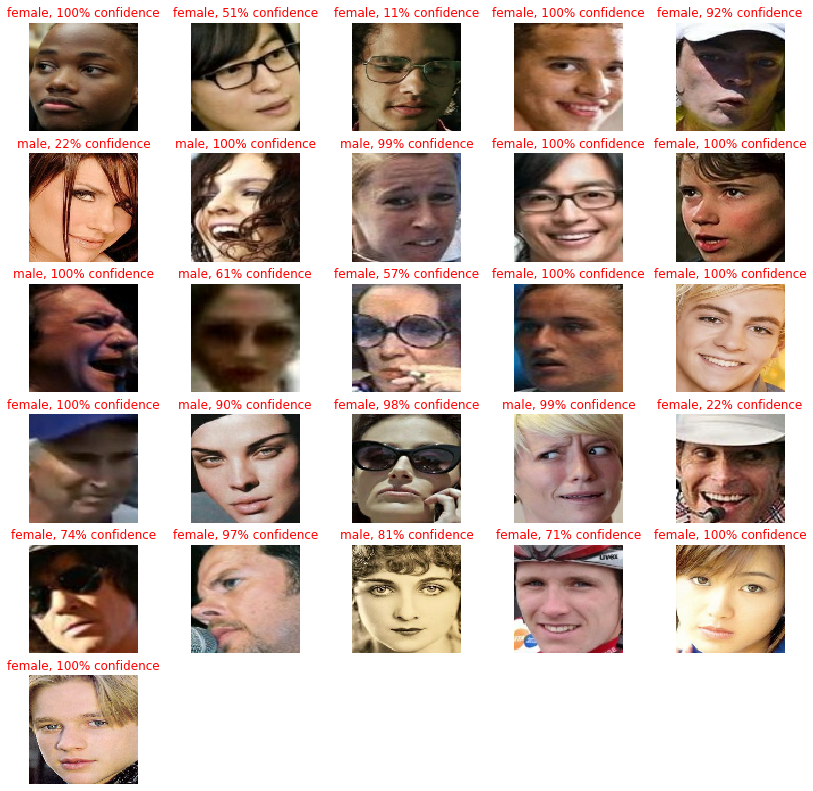

In [39]:
mistakes_mask = np.round(predictions) != labels
plot_predictions(images[mistakes_mask], 
                 predictions[mistakes_mask], 
                 labels[mistakes_mask], 
                 figsize=(14,14), n_cols=5)

Некоторые изображения действительно сбивают с толку. Точно ли это не ошибка в данных? Далее я попробую проверить это.
Но все же, большинство ошибочных изображений легко различимы и значит имеется потенциал для улучшения модели.

Далее, посмотрев на матрицы ошибок с нескольких выборок, я не увидел значительной склонности к одному или другому классу.

In [40]:
# confusion matrix
y_true, y_pred = labels, np.round(predictions)
conf_matr = confusion_matrix(y_true, y_pred)
# Beautification
df_cm = pd.DataFrame(conf_matr, index=["True_Female", "True_Male"], 
                     columns=["Pred_Female", "Pred_Male"])
df_cm

,Pred_Female,Pred_Male
True_Female,494,8
True_Male,18,480


Дальнейшую работу я продолжу в следующем ноутбуке. Я попробую увеличить количество данных путем аугментации, тем самым сильнее обобщая модель. 